<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import json
import pandas as pd
import numpy as np
from time import time

from  pomegranate  import BayesianNetwork
import pygraphviz
import networkx
import tempfile

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

from structure_learning import get_data, discretization

%matplotlib inline 
sns.set(style="white")

In [3]:
# Load the Sub-Saharan migration network based on quantile cuts
with open("model2.json", 'rt') as infile:
        model = BayesianNetwork.from_json(infile.read())

Model with 66 edges.


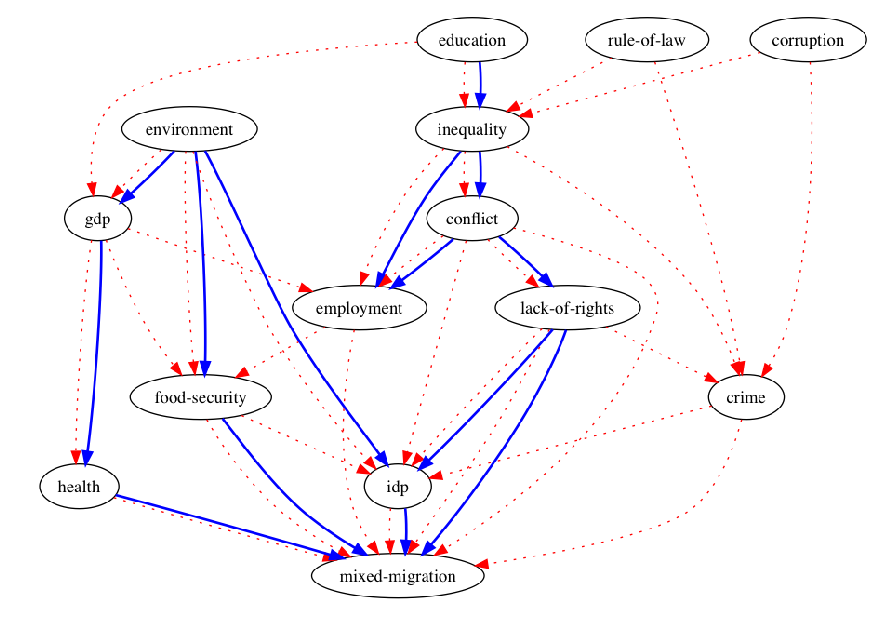

In [4]:
# Get the domain expert network
with open("network.json", 'rt') as infile:
    net = json.load(infile)
    
clus = {i: lbl for lbl, indsets in net['nodes'].items() for i in indsets}
    
G = pygraphviz.AGraph(directed=True, strict=False)
for nodes, _ in net['nodes'].items():
    G.add_node(nodes)

for src, destinations in net['edges'].items():
    for des in destinations:
        G.add_edge(src, des, style='dotted', color='red')
        

print("Model with {} edges.".format(model.edge_count()))

data_links = []
for parent, child in model.edges:
    
    try:
        i = clus[parent.name]
        
        
        try:
            j = clus[child.name]
            
            if (i, j) not in data_links:
                data_links.append((i, j))
            
        except KeyError:
            G.add_node(child.name)
            data_links.append((i, child.name))
    
    except KeyError:
        
        try:
            j = clus[child.name]
            
            G.add_node(parent.name)
            data_links.append((parent.name, j))
            
        except KeyError:
            
            continue

for i, j in data_links:
    G.add_edge(i, j, style='solid', penwidth='2', color='blue')

    
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 15)

with tempfile.NamedTemporaryFile() as tf:
    G.draw(tf.name, format='png', prog='dot')
    img = mpl_image.imread(tf.name)
    plt.imshow(img)
    plt.axis('off')

In [5]:
data = get_data()
X = data.apply(discretization, axis=0)
X.dropna(axis=1, how='all', inplace=True)

Sources            : 9
Row count          : 416790
Geographies        : 353
Indicators         : 85
Temporal coverage  : 1946 -> 2018
Null values        : 30

Loaded data in 0.72 sec.
Column: ACLED.COUNT
Column: ACLED.COUNT
Column: ACLED.FATALITIES
Column: AG.PRD.FOOD.XD
Column: AG.PRD.LVSK.XD
Column: DRC.CORR.INDEX
Column: EG.ELC.ACCS.ZS
Column: EMDAT.CPX.AFFECTED
Column: EMDAT.CPX.OCCURRENCE
Column: EMDAT.CPX.OCCURRENCE +++ Ranked bins
Column: EMDAT.CPX.TOTAL.AFFECTED
Column: EMDAT.CPX.TOTAL.DEATHS
Column: EMDAT.CPX.TOTAL.DEATHS +++ Ranked bins
Column: EMDAT.CPX.TOTAL.DEATHS ------------- ERROR.
Column: EMDAT.NAT.AFFECTED
Column: EMDAT.NAT.HOMELESS
Column: EMDAT.NAT.INJURED
Column: EMDAT.NAT.OCCURRENCE
Column: EMDAT.NAT.OCCURRENCE +++ Ranked bins
Column: EMDAT.NAT.TOTAL.AFFECTED
Column: EMDAT.NAT.TOTAL.DAMAGE
Column: EMDAT.NAT.TOTAL.DEATHS
Column: EMDAT.TEC.AFFECTED
Column: EMDAT.TEC.HOMELESS
Column: EMDAT.TEC.INJURED
Column: EMDAT.TEC.OCCURRENCE
Column: EMDAT.TEC.OCCURRENCE +++ Rank

In [ ]:
from pomegranate.distributions.DiscreteDistribution import DiscreteDistribution

# Get the groups (for labels and inference)
with open("groupings.json", 'rt') as infile:
    GROUPING = json.load(infile)

# Indicators that we use for Scenarios and their relative improvements
INDICATORS = {i['code']: i['direction-improvement'] for grp in GROUPING['clusters'] for i in grp['indicators']}


def get_current_state(X, country="ETH", year=2016):
    """ Returns a dictionary of current indicator values """

    ind = X.loc[(country, year)].tolist()
    lbl = X.columns.tolist()
    
    # Remove missing data
    ind = [None if (x == 'nan')  else x for x in ind]

    # Store current values
    flows = {l: v for (l, v) in zip(lbl, ind) if l.startswith("ETH.TO")}
    
    # Mark outflows as none
    ind = [None if l.startswith("ETH.TO.") else k for (k, l) in zip(ind, lbl)]

    return ind, lbl, flows

def get_subset(g, s, l):
    codes = [t['code'] for t in g]
    out = {i: j for (i, j) in zip(l, s) if l in codes}
    return out

def future_state(g, sl, s, l):
    codes = [t['code'] for t in g]
    return [sl if i in codes else j for (i, j) in zip(l, s)]

def get_adjusted_flows(m, curr_lbl):
    
    out = {}
    for (i, j) in zip(curr_lbl, m.tolist()):
        if isinstance(j, DiscreteDistribution):
            if i.startswith("ETH.TO"):
                out[i] = j.parameters
    return out

    
# Base case
for grp in GROUPING['clusters']:
    
    # dictionary of current values 
    curr_state, curr_lbl, curr_flows = get_current_state(X)
    
    # Scenario - i.e. change individual values
    for s in ['best', 'worse']:
        
        scenario = future_state(grp['indicators'], s, curr_state, curr_lbl)
        print(len(scenario))
        curr_grp = get_subset(grp['indicators'], curr_state, curr_lbl)
        print("Working on theme: {}".format(grp['sub-theme']))
        print("Current state: {}".format(curr_grp))
        print("Current flow: {}".format(curr_flows))
        
        print("Scenario: {}".format(s))
        
        inference = model.predict_proba(scenario)
        model.predict(scenario)
        
        ff = get_adjusted_flows(inference, curr_lbl)
        
        print("Adjusted flows:{}".format(ff))
        
    #modified_states = get_future_state(grp['indicators'])
    